In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = [16, 12]

In [3]:
train_df = pd.read_csv('data/cs-training.csv').drop(['Unnamed: 0'], axis = 1)
test_df = pd.read_csv('data/cs-test.csv').drop(['Unnamed: 0'], axis = 1)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [16]:
train_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TotalNumberOfDaysPastDue
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,0.316284,52.296573,0.245353,334.714559,6.670221e+03,2.088508,0.090293,1.017407,0.064707,0.737327,0.400353
std,0.249746,0.349219,14.768912,0.697231,1025.439058,1.438467e+04,0.598529,0.485107,1.111560,0.329788,1.105968,1.101290
min,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,1.791759,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154178,52.000000,0.000000,0.366508,5.400000e+03,2.197225,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.546947,63.000000,0.000000,0.868254,8.249000e+03,2.484907,0.000000,2.000000,0.000000,1.000000,0.000000
max,1.000000,1.368260,109.000000,13.000000,10000.000000,3.008750e+06,4.077537,17.000000,17.000000,11.000000,10.000000,19.000000


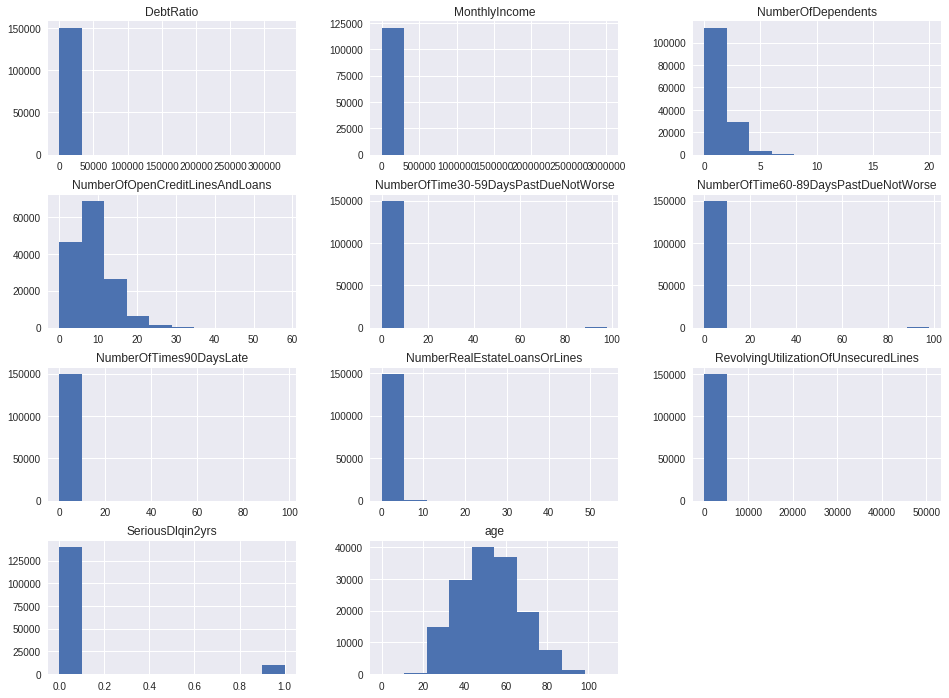

In [5]:
train_df.hist()
plt.show()

In [6]:
from outlier_detection import *

for df in [train_df, test_df]:
    # RevolvingUtilizationOfUnsecuredLines: using MAD
    df.loc[double_mads_from_median(df['RevolvingUtilizationOfUnsecuredLines']) > 3,
           'RevolvingUtilizationOfUnsecuredLines'] = train_df['RevolvingUtilizationOfUnsecuredLines'].median()

    # age: lowerBound
    df.loc[df['age'] < 23, 'age'] = 22

    # DebtRatio: upperBound
    df.loc[df['DebtRatio'] > 10000, 'DebtRatio'] = 10000

    # NumberOfTime*: mapping for values 96 and 98
    for col in ['NumberOfTime30-59DaysPastDueNotWorse',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfTimes90DaysLate']:
        df.loc[(df[col] == 96) | (df[col] == 98), col] = train_df[col].median()

    # NumberRealEstateLoansOrLines: upperBound
    df.loc[df['NumberRealEstateLoansOrLines'] > 17, 'NumberRealEstateLoansOrLines'] = 17

    # NumberOfDependents: upperBound
    df.loc[df['NumberOfDependents'] > 10, 'NumberOfDependents'] = 10

    # NumberOfOpenCreditLinesAndLoans: log1p()
    df['NumberOfOpenCreditLinesAndLoans'] = np.log1p(df['NumberOfOpenCreditLinesAndLoans'])

In [7]:
for df in [train_df, test_df]:
    # NumberOfDependents: using median
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median())

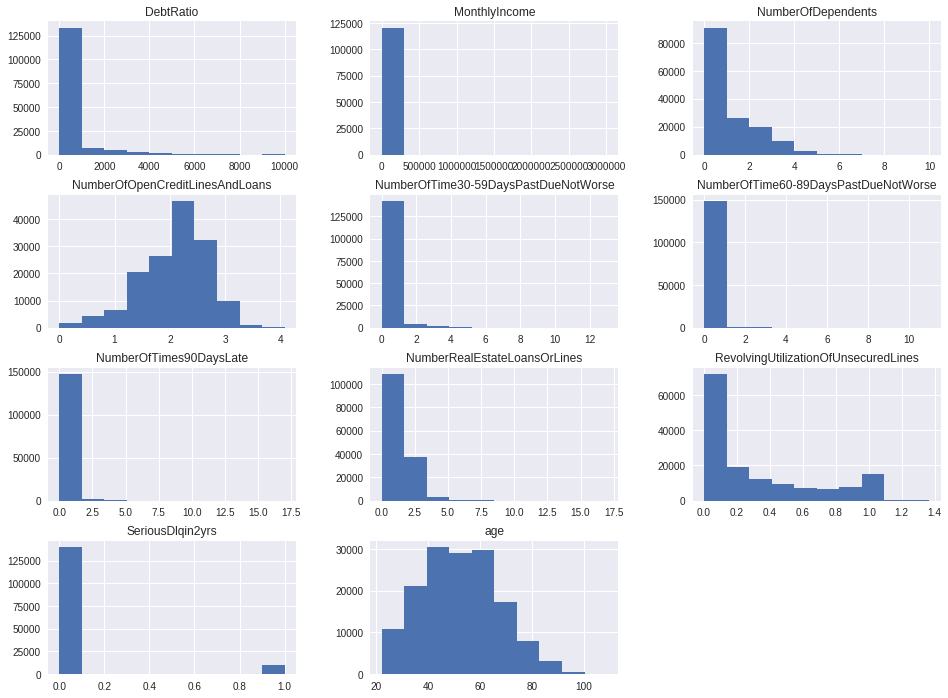

In [8]:
train_df.hist()
plt.show()

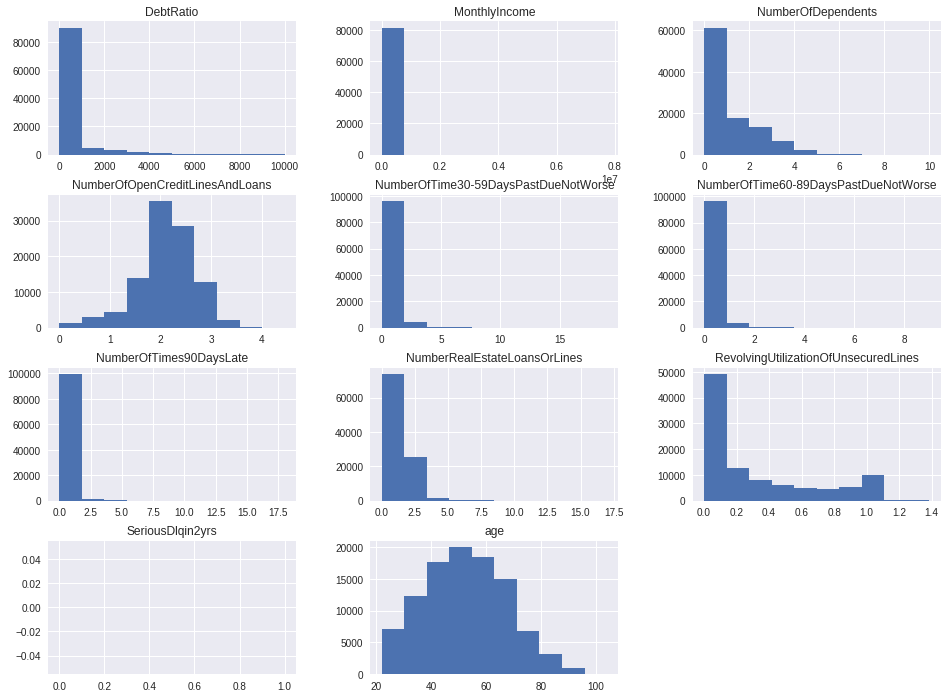

In [9]:
test_df.hist()
plt.show()

In [20]:
for df in [train_df, test_df]:
    df['TotalNumberOfDaysPastDue'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + df['NumberOfTime60-89DaysPastDueNotWorse'] + df['NumberOfTimes90DaysLate']
    
    df['EndOfTheMonth'] = df['MonthlyIncome'] - df['MonthlyIncome'] * df['DebtRatio']

In [21]:
train_df.to_csv('data_extracted/cs-training-prepared.csv', index=False)
test_df.to_csv('data_extracted/cs-test-prepared.csv', index=False)